# 자체적으로 관련 내용 GPT 구현

## acceptance-rejection method

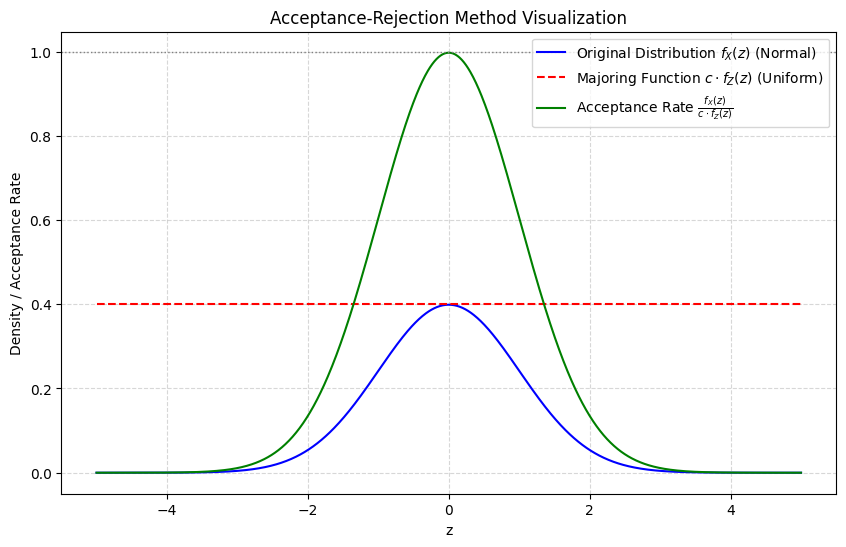

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

# Define the range for z
z = np.linspace(-5, 5, 1000)

# 1. Original Distribution f_X (Standard Normal)
f_X = norm.pdf(z, loc=0, scale=1)  # Mean=0, Std Dev=1

# 2. Majoring Function c * f_Z (Uniform Distribution)
f_Z = uniform.pdf(z, loc=-5, scale=10)  # Uniform over [-5, 5]
c = 4
majoring_function = c * f_Z  # Constant value of 0.4

# 3. Acceptance Rate f_X(z) / (c * f_Z(z))
acceptance_rate = f_X / majoring_function  # Should be <= 1

# Plotting
plt.figure(figsize=(10, 6))

# Plot f_X(z)
plt.plot(z, f_X, label=r'Original Distribution $f_X(z)$ (Normal)', color='blue')

# Plot c * f_Z(z)
plt.plot(z, majoring_function, label=r'Majoring Function $c \cdot f_Z(z)$ (Uniform)', color='red', linestyle='--')

# Plot Acceptance Rate
plt.plot(z, acceptance_rate, label=r'Acceptance Rate $\frac{f_X(z)}{c \cdot f_Z(z)}$', color='green')

# Add horizontal line at acceptance rate = 1
plt.axhline(y=1, color='gray', linestyle=':', linewidth=1)

# Labels and Title
plt.xlabel('z')
plt.ylabel('Density / Acceptance Rate')
plt.title('Acceptance-Rejection Method Visualization')

# Legend
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show Plot
plt.show()


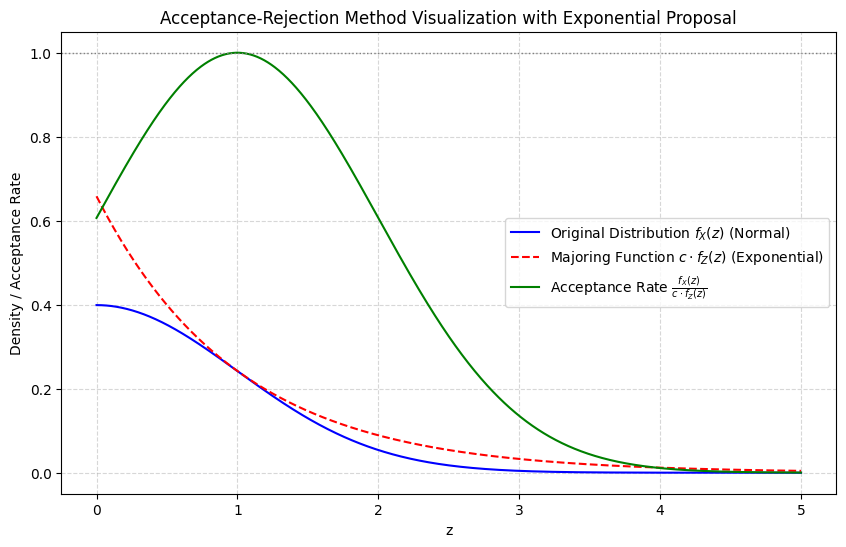

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

# Parameters
lambda_param = 1  # Rate parameter for Exponential distribution
c = 0.658         # Majoring constant calculated to satisfy c * f_Z(z) >= f_X(z) for all z >=0

# Define the range for z (0 to 5 for Exponential)
z = np.linspace(0, 5, 1000)

# 1. Original Distribution f_X (Standard Normal)
f_X = norm.pdf(z, loc=0, scale=1)  # Mean=0, Std Dev=1

# 2. Proposal Distribution f_Z (Exponential)
f_Z = expon.pdf(z, scale=1/lambda_param)  # Exponential with lambda=1

# Majoring Function c * f_Z(z)
majoring_function = c * f_Z  # 0.658 * e^{-z}

# 3. Acceptance Rate f_X(z) / (c * f_Z(z))
acceptance_rate = f_X / majoring_function  # Should be <=1

# Plotting
plt.figure(figsize=(10, 6))

# Plot f_X(z)
plt.plot(z, f_X, label=r'Original Distribution $f_X(z)$ (Normal)', color='blue')

# Plot c * f_Z(z)
plt.plot(z, majoring_function, label=r'Majoring Function $c \cdot f_Z(z)$ (Exponential)', color='red', linestyle='--')

# Plot Acceptance Rate
plt.plot(z, acceptance_rate, label=r'Acceptance Rate $\frac{f_X(z)}{c \cdot f_Z(z)}$', color='green')

# Add horizontal line at acceptance rate = 1
plt.axhline(y=1, color='gray', linestyle=':', linewidth=1)

# Labels and Title
plt.xlabel('z')
plt.ylabel('Density / Acceptance Rate')
plt.title('Acceptance-Rejection Method Visualization with Exponential Proposal')

# Legend
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show Plot
plt.show()


Brownian Bridge

In [4]:
import numpy as np
import time

def ki_digital_bb(s0, maturity, ki_barrier, barrier, gain_coupon, loss_coupon, fulldummy, rfr, div, vol, nSim):
    """
    Pricing a barrier option using the Brownian Bridge method to enhance efficiency.
    
    Parameters:
    - s0: Initial asset price
    - maturity: Time to maturity (in years)
    - ki_barrier: Lower barrier (e.g., 0.7 * s0)
    - barrier: Upper barrier (e.g., 0.8 * s0)
    - gain_coupon: Payoff if S_T >= barrier
    - loss_coupon: Payoff if S_T < barrier and min(S(t)) < ki_barrier
    - fulldummy: Payoff if S_T < barrier and min(S(t)) >= ki_barrier
    - rfr: Risk-free rate
    - div: Dividend yield
    - vol: Volatility of the asset
    - nSim: Number of Monte Carlo simulations
    
    Returns:
    - val: Estimated option price
    - cal_time: Calculation time
    - barrier_prob: Probability that terminal price >= barrier
    """
    start_time = time.time()
    days = 250  # Number of trading days in a year
    ntime = int(days * maturity)  # Total number of time steps
    time_grid = np.linspace(0, maturity, ntime + 1)  # Time grid from 0 to T
    drift = rfr - div - 0.5 * vol ** 2  # Drift component of GBM
    dt = time_grid[1] - time_grid[0]  # Time step size
    
    sum_payoff = 0  # Initialize sum of payoffs
    barrier_prob_cnt = 0  # Count of simulations where S_T >= barrier
    
    # Step 1: Simulate all terminal asset prices at once
    Z_terminal = np.random.normal(size=nSim)  # Generate all terminal Z's
    s_mat = s0 * np.exp(drift * maturity + vol * np.sqrt(maturity) * Z_terminal)  # Terminal prices
    
    # Step 2: Iterate over each simulation
    for i in range(nSim):
        S_T = s_mat[i]  # Terminal price for simulation i
        ratio_T = S_T / s0  # S_T / S0
        
        if ratio_T >= barrier:
            # Case 1: Terminal price exceeds barrier
            payoff = gain_coupon
            barrier_prob_cnt += 1  # Increment barrier exceedance count
        else:
            # Case 2: Terminal price below barrier, need to check for lower barrier breach
            
            # Step 2a: Calculate standardized terminal log-price (Z_T)
            Z_T = (np.log(S_T / s0) - drift * maturity) / vol
            
            # Step 2b: Simulate intermediate Brownian motion (W(t))
            Z_intermediate = np.random.normal(size=ntime)  # Intermediate random variables
            W_t = np.cumsum(Z_intermediate * np.sqrt(dt))  # Simulated Brownian motion path
            
            # Step 2c: Construct the Brownian Bridge
            t_over_T = time_grid / maturity  # t / T
            # Ensure W_t has the same length as time_grid by padding with zero at the start
            W_t_full = np.zeros(ntime + 1)
            W_t_full[1:] = W_t  # Shift W_t by one to align with time_grid
            B_t = Z_T * t_over_T + W_t_full - t_over_T * W_t_full[-1]
            
            # Step 2d: Generate the asset price path using the bridge
            S_t = s0 * np.exp(drift * time_grid + vol * B_t)
            
            # Step 2e: Determine the payoff based on barrier conditions
            min_S_t = np.min(S_t)  # Minimum asset price during the path
            ratio_min = min_S_t / s0  # min(S(t)) / S0
            
            if ratio_min >= ki_barrier:
                # No breach of lower barrier
                payoff = fulldummy
            else:
                # Breach of lower barrier
                payoff = loss_coupon
        
        # Accumulate the payoff
        sum_payoff += payoff
    
    # Step 3: Calculate the discounted average payoff
    avg_payoff = sum_payoff / nSim
    val = round(avg_payoff * np.exp(-rfr * maturity), 3)  # Discounted to present value
    
    # Step 4: Calculate calculation time and barrier exceedance probability
    cal_time = round(time.time() - start_time, 3)
    barrier_prob = round(barrier_prob_cnt / nSim, 3)
    
    return val, cal_time, barrier_prob

# Example Usage:
if __name__ == '__main__':
    # Define parameters
    s0 = 1
    maturity = 1
    ki_barrier = 0.7
    barrier = 0.8
    gain_coupon = 0.10
    loss_coupon = -0.10
    fulldummy = 0.10
    rfr = 0.02
    div = 0
    vol = 0.3
    nSim = 10000
    
    # Run simulations
    val, cal_time, barrier_prob = ki_digital_bb(
        s0, maturity, ki_barrier, barrier,
        gain_coupon, loss_coupon, fulldummy,
        rfr, div, vol, nSim
    )
    
    print('Option Value (BB): {}, Elapsed Time: {} sec, Barrier Exceedance Probability: {}'.format(val, cal_time, barrier_prob))


Option Value (BB): 0.059, Elapsed Time: 0.081 sec, Barrier Exceedance Probability: 0.749


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

def visualize_brownian_bridge_simulation(s0, maturity, ki_barrier, barrier, drift, vol, dt):
    """
    Simulates a single barrier option path using the Brownian Bridge method and visualizes each step.
    """
    # Initialize time grid
    days = int(250 * maturity)
    ntime = days
    time_grid = np.linspace(0, maturity, ntime + 1)
    
    # Step 1: Simulate Terminal Asset Price
    Z_terminal = np.random.normal()
    S_T = s0 * np.exp(drift * maturity + vol * np.sqrt(maturity) * Z_terminal)
    ratio_T = S_T / s0
    print(f"Z_terminal: {Z_terminal:.4f}")
    print(f"Terminal Asset Price (S_T): {S_T:.4f}")
    print(f"Ratio_T: {ratio_T:.4f}")
    
    if ratio_T >= barrier:
        payoff = 0.10  # gain_coupon
        print(f"S_T >= Barrier ({barrier}) --> Payoff: {payoff}")
        
        # Plotting the simple path
        plt.figure(figsize=(12, 6))
        plt.plot([0, maturity], [s0, S_T], marker='o', label='Asset Price Path (S(t))', color='blue')
        plt.axhline(y=barrier, color='green', linestyle='--', label='Barrier (80%)')
        plt.axhline(y=ki_barrier, color='red', linestyle='--', label='Lower Barrier (70%)')
        plt.scatter([0, maturity], [s0, S_T], color='black', zorder=5, label='Start and End Points')
        plt.title('Asset Price Path Above Barrier')
        plt.xlabel('Time (Years)')
        plt.ylabel('Asset Price')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"S_T < Barrier ({barrier}) --> Proceeding to Brownian Bridge")
        
        # Step 2a: Calculate Z_T
        Z_T = (np.log(S_T / s0) - drift * maturity) / vol
        print(f"Z_T: {Z_T:.4f}")
        
        # Step 2b: Simulate Intermediate Brownian Motion W(t)
        Z_intermediate = np.random.normal(size=ntime)
        W_t = np.cumsum(Z_intermediate * np.sqrt(dt))
        
        # Step 2c: Construct the Brownian Bridge B(t)
        t_over_T = time_grid / maturity
        W_t_full = np.zeros(ntime + 1)
        W_t_full[1:] = W_t  # Shift W_t to align with time_grid
        B_t = Z_T * t_over_T + W_t_full - t_over_T * W_t_full[-1]
        
        # Step 2d: Generate Asset Price Path S(t)
        S_t = s0 * np.exp(drift * time_grid + vol * B_t)
        
        # Step 2e: Determine Payoff
        min_S_t = np.min(S_t)
        ratio_min = min_S_t / s0
        print(f"Minimum Asset Price During Path: {min_S_t:.4f}")
        print(f"Ratio_Min: {ratio_min:.4f}")
        
        if ratio_min >= ki_barrier:
            payoff = 0.10  # fulldummy
            print(f"min(S(t)) >= ki_barrier ({ki_barrier}) --> Payoff: {payoff}")
        else:
            payoff = -0.10  # loss_coupon
            print(f"min(S(t)) < ki_barrier ({ki_barrier}) --> Payoff: {payoff}")
        
        # Plotting the Brownian Bridge Asset Price Path
        plt.figure(figsize=(12, 6))
        plt.plot(time_grid, S_t, label='Asset Price Path (S(t))', color='blue')
        plt.axhline(y=barrier, color='green', linestyle='--', label='Barrier (80%)')
        plt.axhline(y=ki_barrier, color='red', linestyle='--', label='Lower Barrier (70%)')
        plt.scatter([0, maturity], [s0, S_T], color='black', zorder=5, label='Start and End Points')
        plt.title('Asset Price Path Using Brownian Bridge')
        plt.xlabel('Time (Years)')
        plt.ylabel('Asset Price')
        plt.legend()
        plt.grid(True)
        plt.show()


Z_terminal: 0.7488
Terminal Asset Price (S_T): 1.2210
Ratio_T: 1.2210
S_T >= Barrier (0.8) --> Payoff: 0.1


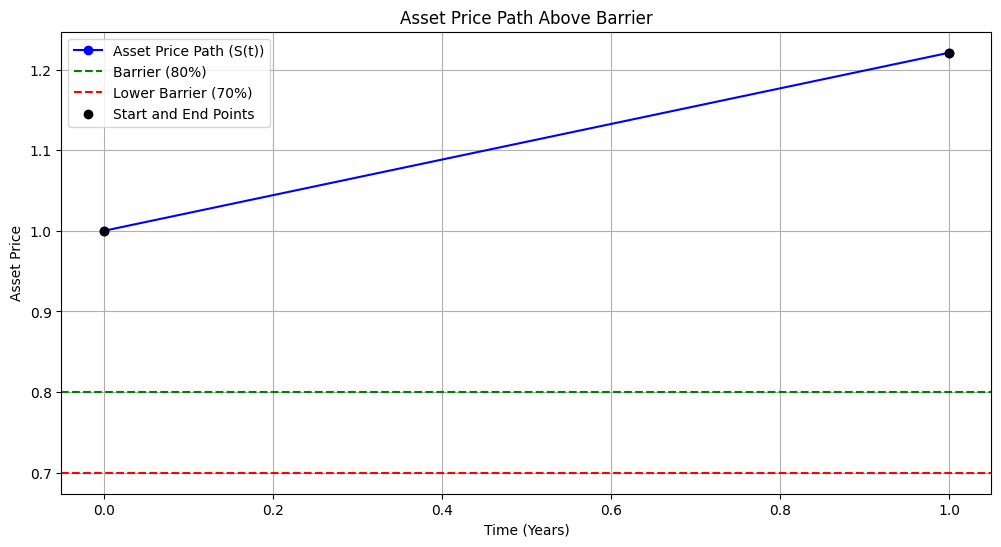

In [6]:
# Define parameters
s0 = 1
maturity = 1
ki_barrier = 0.7
barrier = 0.8
drift = 0.02 - 0 - 0.5 * 0.3 ** 2  # rfr - div - 0.5 * sigma^2
vol = 0.3
dt = 1 / 250  # Assuming 250 trading days

# Visualize a single simulation
visualize_brownian_bridge_simulation(s0, maturity, ki_barrier, barrier, drift, vol, dt)


Z_terminal: 0.3176
Terminal Asset Price (S_T): 1.0728
Ratio_T: 1.0728
S_T >= Barrier (0.8) --> Payoff: 0.1


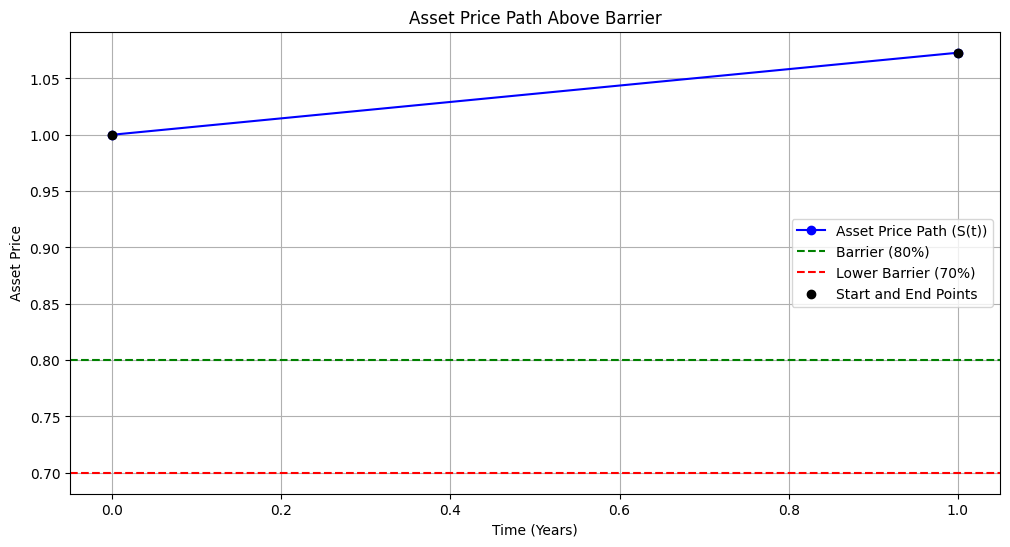

--------------------------------------------------------------------------------
Z_terminal: -1.7536
Terminal Asset Price (S_T): 0.5763
Ratio_T: 0.5763
S_T < Barrier (0.8) --> Proceeding to Brownian Bridge
Z_T: -1.7536
Minimum Asset Price During Path: 0.5763
Ratio_Min: 0.5763
min(S(t)) < ki_barrier (0.7) --> Payoff: -0.1


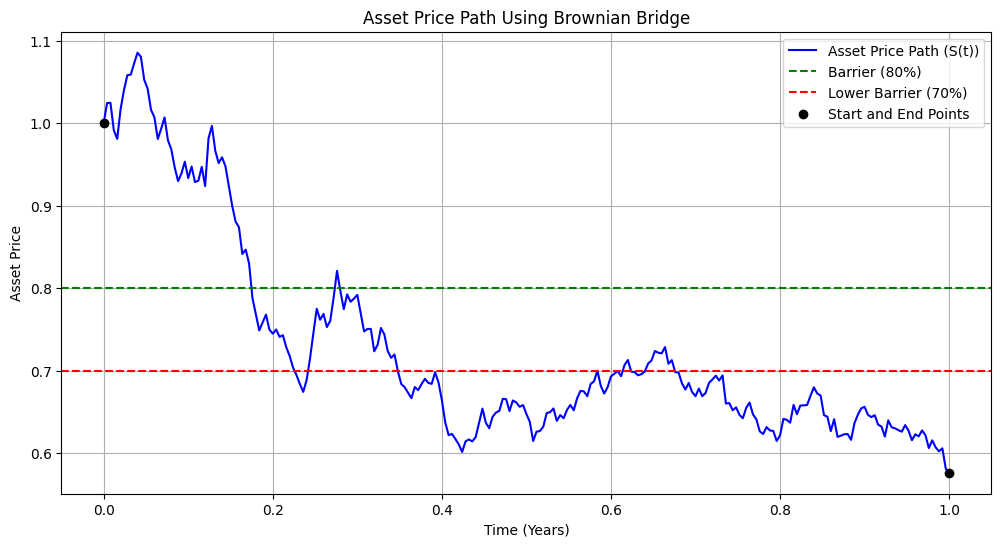

--------------------------------------------------------------------------------
Z_terminal: -0.3759
Terminal Asset Price (S_T): 0.8713
Ratio_T: 0.8713
S_T >= Barrier (0.8) --> Payoff: 0.1


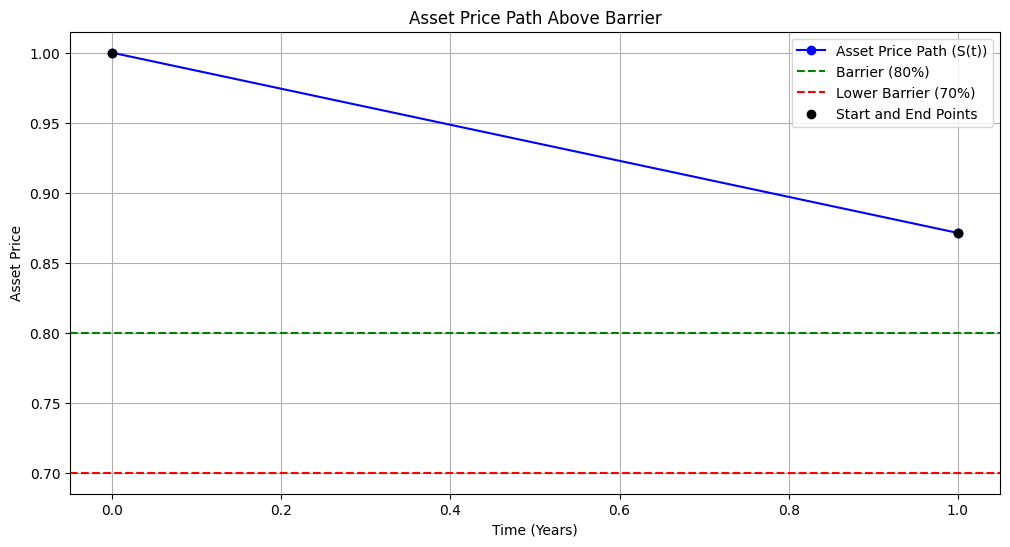

--------------------------------------------------------------------------------


In [7]:
def run_multiple_simulations(nSim):
    for _ in range(nSim):
        visualize_brownian_bridge_simulation(s0, maturity, ki_barrier, barrier, drift, vol, dt)
        print("-" * 80)

# Run 3 simulations
run_multiple_simulations(3)


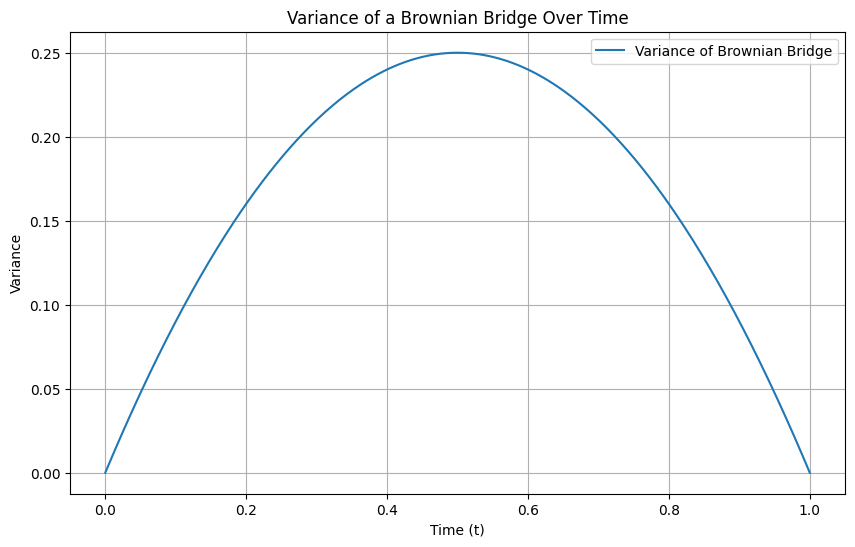

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1  # Total time
time_grid = np.linspace(0, T, 500)  # Time points
variance = (time_grid * (T - time_grid)) / T  # Variance at each time t

# Plotting the variance
plt.figure(figsize=(10, 6))
plt.plot(time_grid, variance, label='Variance of Brownian Bridge')
plt.title('Variance of a Brownian Bridge Over Time')
plt.xlabel('Time (t)')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\chlje\AppData\Local\Temp\ipykernel_22992\1981786774.py:20: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(pdf, x)


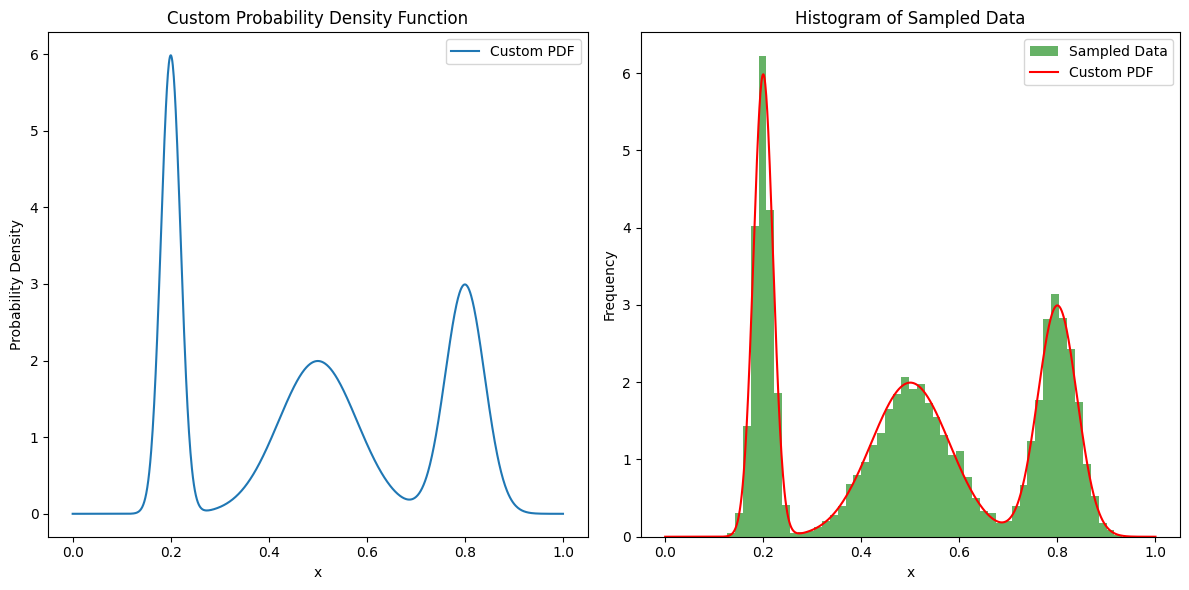

Number of peaks detected in the PDF: 3
Peak locations: [0.2002002 0.5005005 0.7997998]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import simps

# 1. Define Parameters for the Three Normal Distributions
# Ensure means are within [0, 1]
means = [0.2, 0.5, 0.8]          # Centers of the hills
std_devs = [0.02, 0.08, 0.04]    # Standard deviations (left: pointy, middle: broad, right: less pointy)
weights = [0.3, 0.4, 0.3]         # Weights for each component

# 2. Create the Custom PDF
x = np.linspace(0, 1, 1000)
pdf = np.zeros_like(x)

for mean, std, weight in zip(means, std_devs, weights):
    pdf += weight * norm.pdf(x, mean, std)

# Normalize the PDF to ensure it integrates to 1 over [0,1]
integral = simps(pdf, x)
pdf /= integral

# 3. Compute the CDF
cdf = np.cumsum(pdf)
cdf /= cdf[-1]  # Normalize CDF to 1

# 4. Inverse Transform Sampling
def sample_from_custom_pdf(cdf, x, num_samples):
    # Generate uniform random numbers
    u = np.random.uniform(0, 1, num_samples)
    # Use interpolation to find the corresponding x values
    samples = np.interp(u, cdf, x)
    return samples

# Generate Samples
num_samples = 10000
samples = sample_from_custom_pdf(cdf, x, num_samples)

# 5. Visualization
plt.figure(figsize=(12, 6))

# Plot the PDF
plt.subplot(1, 2, 1)
plt.plot(x, pdf, label='Custom PDF')
plt.title('Custom Probability Density Function')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

# Plot the Histogram of Samples
plt.subplot(1, 2, 2)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Sampled Data')
plt.plot(x, pdf, 'r-', label='Custom PDF')
plt.title('Histogram of Sampled Data')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# 6. Verify the Number of Hills
from scipy.signal import find_peaks

peaks, _ = find_peaks(pdf, height=0.01)  # Adjust height threshold as needed
print(f"Number of peaks detected in the PDF: {len(peaks)}")
print(f"Peak locations: {x[peaks]}")


C:\Users\chlje\AppData\Local\Temp\ipykernel_36724\2831583645.py:20: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(pdf, x)


Strata Thresholds:
Stratum 1: [0.0000, 0.1909)
Stratum 2: [0.1909, 0.2081)
Stratum 3: [0.2081, 0.2581)
Stratum 4: [0.2581, 0.4455)
Stratum 5: [0.4455, 0.4995)
Stratum 6: [0.4995, 0.5535)
Stratum 7: [0.5535, 0.7022)
Stratum 8: [0.7022, 0.7823)
Stratum 9: [0.7823, 0.8167)
Stratum 10: [0.8167, 1.0000)

Stratum Weights:
Stratum 1: 0.1005
Stratum 2: 0.0992
Stratum 3: 0.0995
Stratum 4: 0.0992
Stratum 5: 0.0999
Stratum 6: 0.0996
Stratum 7: 0.1002
Stratum 8: 0.1009
Stratum 9: 0.1005
Stratum 10: 0.1005

Population Mean: 0.5005
Uniform Sampling Mean: 0.4969
Stratified Sampling Mean: 0.5011


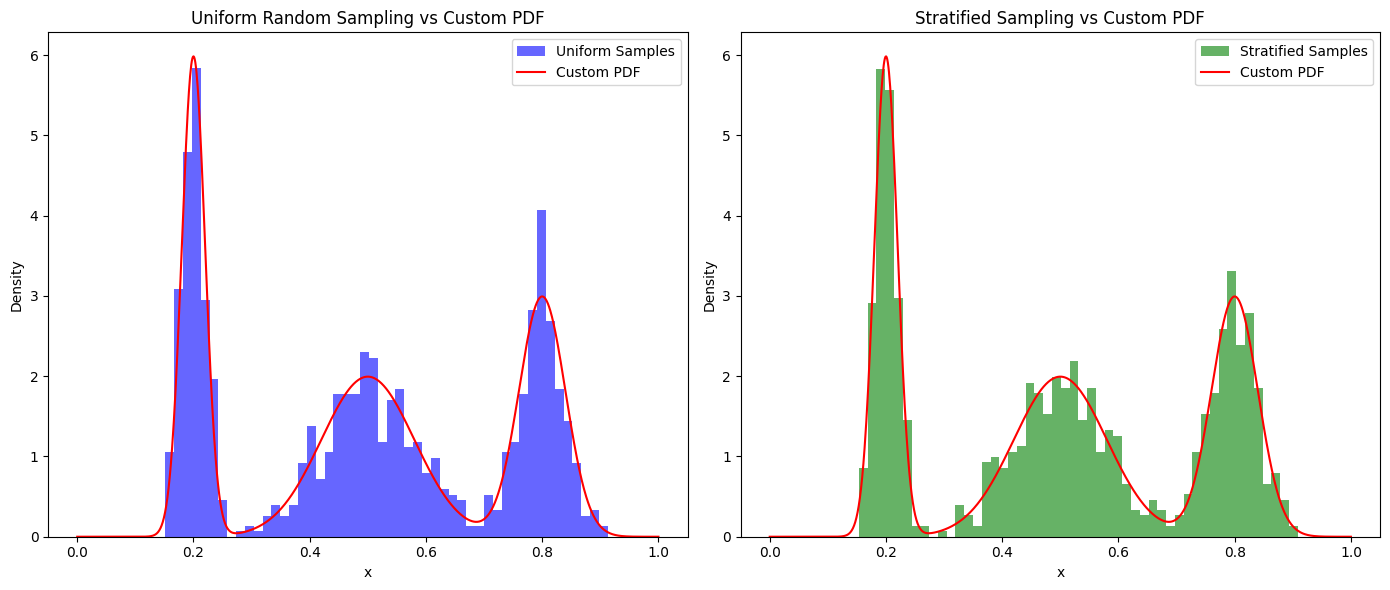

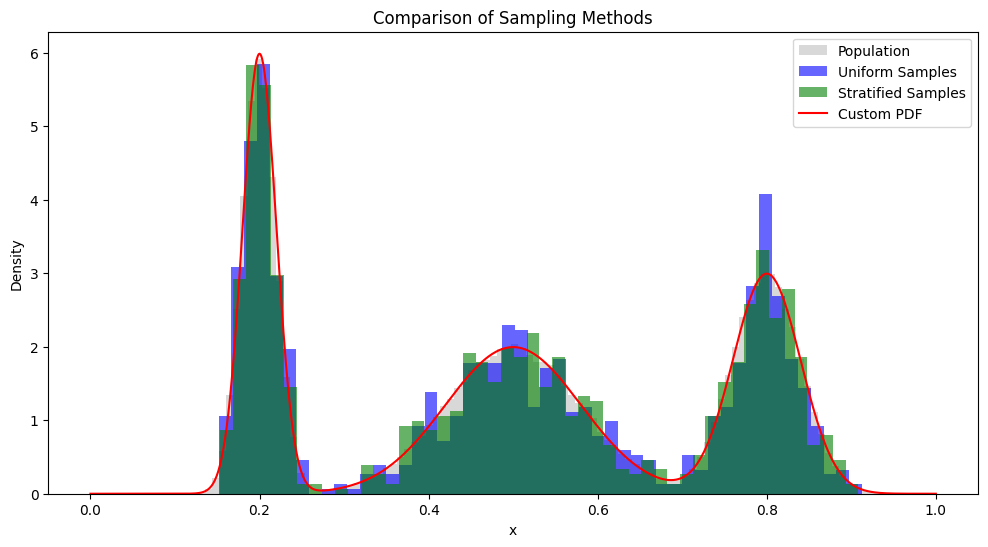


Number of peaks detected in the PDF: 3
Peak locations: [0.2002002 0.5005005 0.7997998]


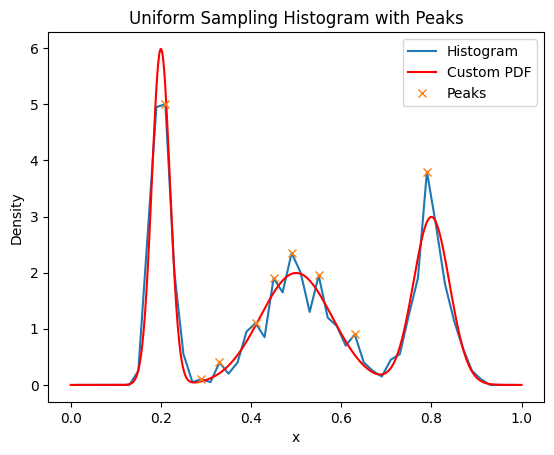

Number of peaks detected: 9 at locations: [0.21 0.29 0.33 0.41 0.45 0.49 0.55 0.63 0.79]


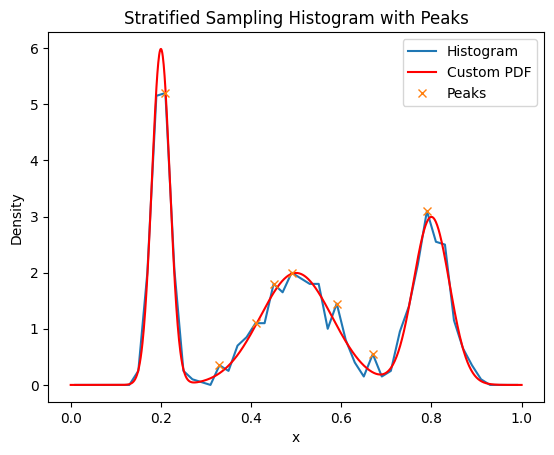

Number of peaks detected: 8 at locations: [0.21 0.33 0.41 0.45 0.49 0.59 0.67 0.79]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import simps
from scipy.signal import find_peaks

# 1. Define Parameters for the Three Normal Distributions
means = [0.2, 0.5, 0.8]          # Centers of the hills
std_devs = [0.02, 0.08, 0.04]    # Standard deviations
weights = [0.3, 0.4, 0.3]         # Weights for each component

# 2. Create the Custom PDF
x = np.linspace(0, 1, 1000)
pdf = np.zeros_like(x)

for mean, std, weight in zip(means, std_devs, weights):
    pdf += weight * norm.pdf(x, mean, std)

# Normalize the PDF to ensure it integrates to 1 over [0,1]
integral = simps(pdf, x)
pdf /= integral

# 3. Compute the CDF
cdf = np.cumsum(pdf)
cdf /= cdf[-1]  # Normalize CDF to 1

# 4. Inverse Transform Sampling Function
def sample_from_custom_pdf(cdf, x, num_samples):
    # Generate uniform random numbers
    u = np.random.uniform(0, 1, num_samples)
    # Use interpolation to find the corresponding x values
    samples = np.interp(u, cdf, x)
    return samples

# 5. Generate a Large Population (e.g., 200,000 samples)
population_size = 200000
population = sample_from_custom_pdf(cdf, x, population_size)

# 6. Perform Uniform Random Sampling (n=1000)
n_samples = 1000
uniform_samples = np.random.choice(population, size=n_samples, replace=False)

# 7. Create 10 Strata Based on the CDF
strata_cdf_values = np.linspace(0.1, 0.9, 9)  # 0.1, 0.2, ..., 0.9
strata_thresholds = np.interp(strata_cdf_values, cdf, x)
strata_thresholds = np.concatenate(([0], strata_thresholds, [1]))  # Include 0 and 1

# Display Strata Thresholds
print("Strata Thresholds:")
for i in range(10):
    print(f"Stratum {i+1}: [{strata_thresholds[i]:.4f}, {strata_thresholds[i+1]:.4f})")

# 8. Calculate Stratum Weights
stratum_counts = []
stratum_weights = []
for i in range(10):
    lower = strata_thresholds[i]
    upper = strata_thresholds[i+1]
    count = np.sum((population >= lower) & (population < upper))
    stratum_counts.append(count)
    stratum_weights.append(count / population_size)

# Display Stratum Weights
print("\nStratum Weights:")
for i, weight in enumerate(stratum_weights):
    print(f"Stratum {i+1}: {weight:.4f}")

# 9. Perform Stratified Sampling (n=1000)
stratified_samples = []
samples_per_stratum = np.round(n_samples * np.array(stratum_weights)).astype(int)

# Adjust to ensure total samples equal to n_samples
difference = n_samples - samples_per_stratum.sum()
if difference > 0:
    samples_per_stratum[:difference] += 1
elif difference < 0:
    samples_per_stratum[:abs(difference)] -= 1

for i in range(10):
    lower = strata_thresholds[i]
    upper = strata_thresholds[i+1]
    stratum_data = population[(population >= lower) & (population < upper)]
    if len(stratum_data) == 0:
        continue  # Skip if no data in stratum
    samples_needed = samples_per_stratum[i]
    if samples_needed > len(stratum_data):
        # If not enough data, sample with replacement
        sampled = np.random.choice(stratum_data, size=samples_needed, replace=True)
    else:
        sampled = np.random.choice(stratum_data, size=samples_needed, replace=False)
    stratified_samples.extend(sampled)

stratified_samples = np.array(stratified_samples)

# 10. Visualization and Comparison

# Compute Statistics
population_mean = np.mean(population)
uniform_mean = np.mean(uniform_samples)
stratified_mean = np.mean(stratified_samples)

print(f"\nPopulation Mean: {population_mean:.4f}")
print(f"Uniform Sampling Mean: {uniform_mean:.4f}")
print(f"Stratified Sampling Mean: {stratified_mean:.4f}")

# Plot Histograms
plt.figure(figsize=(14, 6))

# Histogram for Uniform Sampling
plt.subplot(1, 2, 1)
plt.hist(uniform_samples, bins=50, density=True, alpha=0.6, color='blue', label='Uniform Samples')
plt.plot(x, pdf, 'r-', label='Custom PDF')
plt.title('Uniform Random Sampling vs Custom PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

# Histogram for Stratified Sampling
plt.subplot(1, 2, 2)
plt.hist(stratified_samples, bins=50, density=True, alpha=0.6, color='green', label='Stratified Samples')
plt.plot(x, pdf, 'r-', label='Custom PDF')
plt.title('Stratified Sampling vs Custom PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Additional Visualization: Compare Sampling Distributions
plt.figure(figsize=(12, 6))
plt.hist(population, bins=100, density=True, alpha=0.3, label='Population', color='gray')
plt.hist(uniform_samples, bins=50, density=True, alpha=0.6, label='Uniform Samples', color='blue')
plt.hist(stratified_samples, bins=50, density=True, alpha=0.6, label='Stratified Samples', color='green')
plt.plot(x, pdf, 'r-', label='Custom PDF')
plt.title('Comparison of Sampling Methods')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

# 11. Verify the Number of Hills in the Population PDF
peaks, _ = find_peaks(pdf, height=0.005)  # Adjust height threshold as needed
print(f"\nNumber of peaks detected in the PDF: {len(peaks)}")
print(f"Peak locations: {x[peaks]}")

# 12. Verify the Number of Hills in Sampling PDFs
# Function to detect peaks
def detect_peaks(data, title):
    hist, bin_edges = np.histogram(data, bins=50, range=(0,1), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    peaks, _ = find_peaks(hist, height=0.005)
    plt.plot(bin_centers, hist, label='Histogram')
    plt.plot(x, pdf, 'r-', label='Custom PDF')
    plt.plot(bin_centers[peaks], hist[peaks], "x", label='Peaks')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    print(f"Number of peaks detected: {len(peaks)} at locations: {bin_centers[peaks]}")

# Detect peaks in Uniform Sampling
detect_peaks(uniform_samples, 'Uniform Sampling Histogram with Peaks')

# Detect peaks in Stratified Sampling
detect_peaks(stratified_samples, 'Stratified Sampling Histogram with Peaks')


In [2]:
stratum_counts # cdf에서 equal하게 잘랐으므로, 각 stratum의 count가 비슷할 것이다.

[19951, 20095, 20106, 20097, 19915, 19932, 20134, 19870, 19845, 20055]

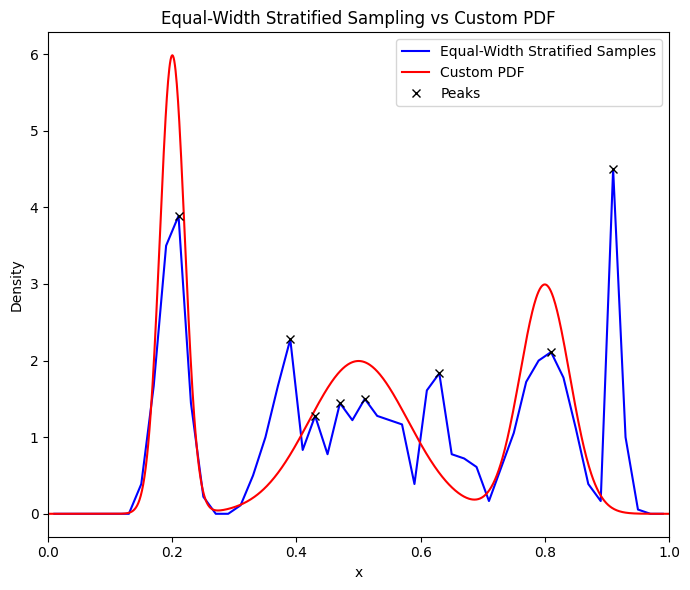

Number of peaks detected in Equal-Width Stratified Sampling Histogram: 8
Peak locations: [0.21 0.39 0.43 0.47 0.51 0.63 0.81 0.91]


In [3]:
# 13. Define Equal-Width Strata
equal_width_strata = np.linspace(0, 1, 11)  # 0.0, 0.1, 0.2, ..., 1.0

# 14. Perform Equal-Width Stratified Sampling (n=1000, 100 per stratum)
equal_width_samples = []
samples_per_stratum_eq = 100  # 100 samples per stratum

for i in range(10):
    lower = equal_width_strata[i]
    upper = equal_width_strata[i+1]
    # Extract population data within the current stratum
    stratum_data_eq = population[(population >= lower) & (population < upper)]
    if len(stratum_data_eq) == 0:
        # If no data in stratum, skip sampling
        continue
    # Sample uniformly within the stratum
    # If insufficient data, sample with replacement
    if len(stratum_data_eq) < samples_per_stratum_eq:
        sampled_eq = np.random.choice(stratum_data_eq, size=samples_per_stratum_eq, replace=True)
    else:
        sampled_eq = np.random.choice(stratum_data_eq, size=samples_per_stratum_eq, replace=False)
    equal_width_samples.extend(sampled_eq)

equal_width_samples = np.array(equal_width_samples)

# 15. Plot the Histogram Comparing Equal-Width Stratified Sampling with Custom PDF

# Compute histogram data
hist_eq, bin_edges_eq = np.histogram(equal_width_samples, bins=50, range=(0,1), density=True)
bin_centers_eq = (bin_edges_eq[:-1] + bin_edges_eq[1:]) / 2

# Detect peaks in the histogram
peaks_eq, properties_eq = find_peaks(hist_eq, height=0.005)  # Adjust height threshold as needed

plt.figure(figsize=(7, 6))

# Plot the histogram of equal-width stratified samples as a blue line
plt.plot(bin_centers_eq, hist_eq, color='blue', label='Equal-Width Stratified Samples')

# Overlay the custom PDF in red
plt.plot(x, pdf, 'r-', label='Custom PDF')

# Mark the peaks with 'x' markers in black
plt.plot(bin_centers_eq[peaks_eq], hist_eq[peaks_eq], "x", color='black', label='Peaks')

# Set x-axis limits to [0,1] to ensure the PDF is bounded correctly
plt.xlim(0, 1)

plt.title('Equal-Width Stratified Sampling vs Custom PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# 16. Print Peak Information (Optional)
print(f"Number of peaks detected in Equal-Width Stratified Sampling Histogram: {len(peaks_eq)}")
print(f"Peak locations: {bin_centers_eq[peaks_eq]}")



Updated Strata Thresholds:
Stratum 1: [0.0000, 0.1909)
Stratum 2: [0.1909, 0.2081)
Stratum 3: [0.2081, 0.2581)
Stratum 4: [0.2581, 0.4455)
Stratum 5: [0.4455, 0.4995)
Stratum 6: [0.4995, 0.5535)
Stratum 7: [0.5535, 0.7022)
Stratum 8: [0.7022, 0.7823)
Stratum 9: [0.7823, 0.8167)
Stratum 10: [0.8167, 1.0000)

Updated Stratum Weights:
Stratum 1: 0.1001
Stratum 2: 0.0999
Stratum 3: 0.1004
Stratum 4: 0.0986
Stratum 5: 0.1014
Stratum 6: 0.0994
Stratum 7: 0.1008
Stratum 8: 0.1009
Stratum 9: 0.0992
Stratum 10: 0.0993


C:\Users\chlje\AppData\Local\Temp\ipykernel_36724\452931737.py:21: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(pdf, x)
C:\Users\chlje\AppData\Local\Temp\ipykernel_36724\452931737.py:124: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  chunk_integral = simps(chunk_pdf, chunk_x)


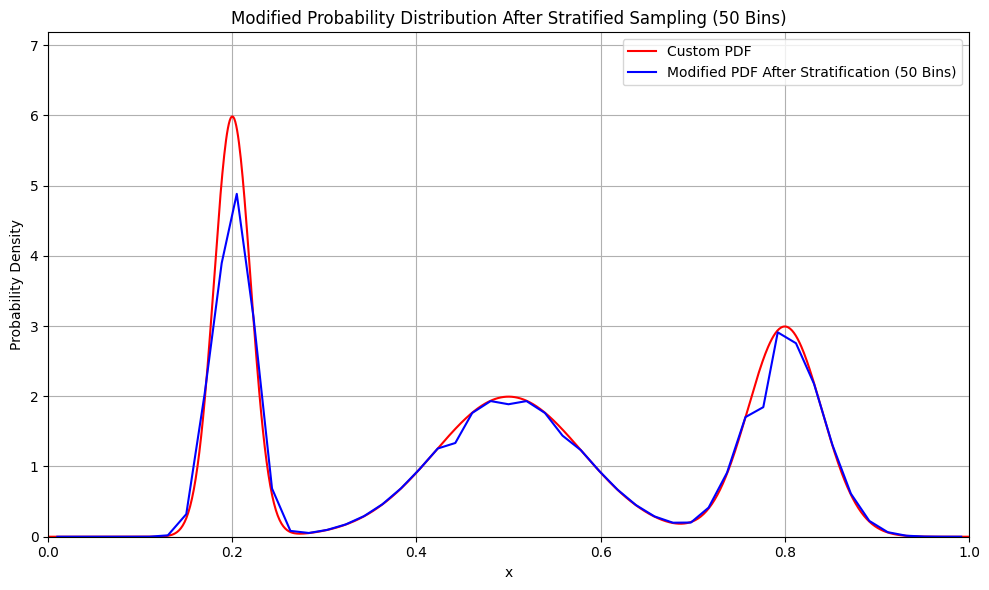


Total probability after stratification (50 chunks): 1.0000


In [16]:
from scipy.stats import truncnorm

# 13. Redefine the Custom PDF using Truncated Normal Distributions
def get_truncnorm_pdf(mean, std, x, lower=0, upper=1):
    """
    Returns the PDF of a truncated normal distribution at points x.
    """
    a, b = (lower - mean) / std, (upper - mean) / std
    trunc_pdf = truncnorm.pdf(x, a, b, loc=mean, scale=std)
    return trunc_pdf

# Reset the PDF
pdf = np.zeros_like(x)

# Create the truncated normal components and sum them
for mean, std, weight in zip(means, std_devs, weights):
    trunc_pdf = weight * get_truncnorm_pdf(mean, std, x)
    pdf += trunc_pdf

# Normalize the PDF to ensure it integrates to 1 over [0,1]
integral = simps(pdf, x)
pdf /= integral

# 14. Recompute the CDF with the Updated PDF
cdf = np.cumsum(pdf)
cdf /= cdf[-1]  # Normalize CDF to 1

# 15. Regenerate the Population with the Corrected PDF
population = sample_from_custom_pdf(cdf, x, population_size)

# 16. Recalculate Strata Thresholds Based on the New CDF
strata_cdf_values = np.linspace(0.1, 0.9, 9)  # 0.1, 0.2, ..., 0.9
strata_thresholds = np.interp(strata_cdf_values, cdf, x)
strata_thresholds = np.concatenate(([0], strata_thresholds, [1]))  # Include 0 and 1

# Display Updated Strata Thresholds
print("\nUpdated Strata Thresholds:")
for i in range(10):
    print(f"Stratum {i+1}: [{strata_thresholds[i]:.4f}, {strata_thresholds[i+1]:.4f})")

# 17. Recalculate Stratum Weights with the New Population
stratum_counts = []
stratum_weights = []
for i in range(10):
    lower = strata_thresholds[i]
    upper = strata_thresholds[i+1]
    count = np.sum((population >= lower) & (population < upper))
    stratum_counts.append(count)
    stratum_weights.append(count / population_size)

# Display Updated Stratum Weights
print("\nUpdated Stratum Weights:")
for i, weight in enumerate(stratum_weights):
    print(f"Stratum {i+1}: {weight:.4f}")

# 18. Re-perform Stratified Sampling with the Corrected Population and Weights
stratified_samples = []
samples_per_stratum = np.round(n_samples * np.array(stratum_weights)).astype(int)

# Adjust to ensure total samples equal to n_samples
difference = n_samples - samples_per_stratum.sum()
if difference > 0:
    samples_per_stratum[:difference] += 1
elif difference < 0:
    samples_per_stratum[:abs(difference)] -= 1

for i in range(10):
    lower = strata_thresholds[i]
    upper = strata_thresholds[i+1]
    stratum_data = population[(population >= lower) & (population < upper)]
    if len(stratum_data) == 0:
        continue  # Skip if no data in stratum
    samples_needed = samples_per_stratum[i]
    if samples_needed > len(stratum_data):
        # If not enough data, sample with replacement
        sampled = np.random.choice(stratum_data, size=samples_needed, replace=True)
    else:
        sampled = np.random.choice(stratum_data, size=samples_needed, replace=False)
    stratified_samples.extend(sampled)

stratified_samples = np.array(stratified_samples)

# 19. Define Chunk Size and Initialize Lists for Modified PDF
chunks_per_merge = 4  # Number of small chunks to merge into one
small_chunk_size = 0.005  # Original small chunk size

# Initialize lists to store small chunk centers and their probabilities
small_chunk_centers = []
small_chunk_probabilities = []

# Divide Each Stratum into Small Chunks and Assign Probabilities Based on PDF Density
for i in range(10):
    lower = strata_thresholds[i]
    upper = strata_thresholds[i+1]
    stratum_weight = stratum_weights[i]
    
    # Calculate the number of full small chunks within the stratum
    num_full_small_chunks = int((upper - lower) // small_chunk_size)
    
    # Calculate remaining range after full small chunks
    remaining_small = (upper - lower) - (num_full_small_chunks * small_chunk_size)
    
    # Total number of small chunks (including the last partial chunk if any)
    total_small_chunks = num_full_small_chunks + (1 if remaining_small > 1e-8 else 0)
    
    # Assign probability per small chunk based on PDF density
    for j in range(total_small_chunks):
        chunk_lower = lower + j * small_chunk_size
        chunk_upper = chunk_lower + small_chunk_size
        if j == total_small_chunks - 1 and remaining_small > 1e-8:
            # Last chunk may be smaller
            chunk_upper = upper
            actual_chunk_size = chunk_upper - chunk_lower
        else:
            actual_chunk_size = small_chunk_size
        
        # Calculate chunk center
        chunk_center = chunk_lower + actual_chunk_size / 2
        small_chunk_centers.append(chunk_center)
        
        # Compute the integral of the PDF over the small chunk using Simpson's rule
        chunk_x = np.linspace(chunk_lower, chunk_upper, 100)  # 100 points per small chunk for accuracy
        chunk_pdf = np.interp(chunk_x, x, pdf)
        chunk_integral = simps(chunk_pdf, chunk_x)
        
        # Assign the small chunk's probability
        small_chunk_probabilities.append(chunk_integral)

# 20. Merge Every 4 Small Chunks into 1 Larger Chunk
total_small_chunks = len(small_chunk_centers)
if total_small_chunks % chunks_per_merge != 0:
    # If not divisible, trim the excess small chunks
    excess = total_small_chunks % chunks_per_merge
    small_chunk_centers = small_chunk_centers[:-excess]
    small_chunk_probabilities = small_chunk_probabilities[:-excess]
    total_small_chunks = len(small_chunk_centers)

# Reshape the small chunks into groups of 4
small_chunk_centers_reshaped = np.array(small_chunk_centers).reshape(-1, chunks_per_merge)
small_chunk_probabilities_reshaped = np.array(small_chunk_probabilities).reshape(-1, chunks_per_merge)

# Calculate merged chunk centers and probabilities
merged_chunk_centers = small_chunk_centers_reshaped.mean(axis=1)
merged_chunk_probabilities = small_chunk_probabilities_reshaped.sum(axis=1) / (chunks_per_merge * small_chunk_size)

# 21. Plot the Modified Probability Distribution After Stratification (50 Bins)
plt.figure(figsize=(10, 6))

# Plot the original custom PDF in red
plt.plot(x, pdf, 'r-', label='Custom PDF')

# Plot the modified PDF after stratification in blue
plt.plot(merged_chunk_centers, merged_chunk_probabilities, 'b-', label='Modified PDF After Stratification (50 Bins)', )

plt.title('Modified Probability Distribution After Stratified Sampling (50 Bins)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, max(pdf)*1.2)  # Adjust y-axis for better visibility

plt.tight_layout()
plt.show()

# 22. Verification of Total Probability
total_prob_merged = merged_chunk_probabilities.sum() * (chunks_per_merge * small_chunk_size)
print(f"\nTotal probability after stratification (50 chunks): {total_prob_merged:.4f}")


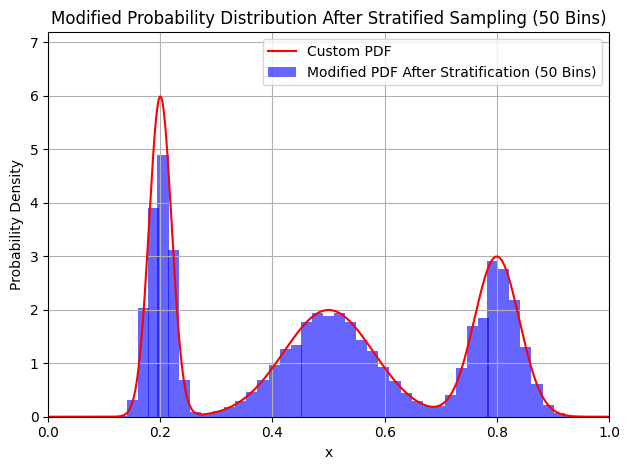

In [17]:
# Plot the original custom PDF in red
plt.plot(x, pdf, 'r-', label='Custom PDF')

# Plot the modified PDF after stratification as a blue bar graph
plt.bar(
    merged_chunk_centers,                  # X-coordinates (centers of the merged chunks)
    merged_chunk_probabilities,            # Heights of the bars (probability densities)
    width=0.02,                            # Width of each bar (merged chunk size)
    color='b',                             # Color of the bars
    alpha=0.6,                             # Transparency of the bars
    label='Modified PDF After Stratification (50 Bins)',
    align='center'                         # Align bars to the center of x-coordinates
)

# Enhance the plot with titles and labels
plt.title('Modified Probability Distribution After Stratified Sampling (50 Bins)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

# Set the limits for better visualization
plt.xlim(0, 1)
plt.ylim(0, max(pdf)*1.2)  # Adjust y-axis to accommodate the highest probability

# Adjust layout for neatness and display the plot
plt.tight_layout()
plt.show()
